In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from scipy.stats import normaltest, norm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVR
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from tabulate import tabulate

from google.colab import files
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

# TODO: Load and display the dataset
data = pd.read_csv('/content/drive/MyDrive/final_dataset.csv')

data.head(10)

,valence,acousticness,danceability,explicit,track_genre,loudness,popularity
0,0.7150,0.0322,0.676,False,acoustic,-6.746,13
1,0.2670,0.9240,0.420,False,acoustic,-17.235,47
2,0.1200,0.2100,0.438,False,acoustic,-9.734,6
3,0.1430,0.9050,0.266,False,acoustic,-18.515,51
4,0.1670,0.4690,0.618,False,acoustic,-9.681,21
5,0.6660,0.2890,0.688,False,acoustic,-8.807,16
6,0.0765,0.8570,0.407,False,acoustic,-8.822,36
7,0.7120,0.5590,0.703,False,acoustic,-9.331,17
8,0.6690,0.2940,0.625,False,acoustic,-8.700,14
9,0.1960,0.4260,0.442,False,acoustic,-6.770,17


In [ ]:
data.shape

(113999, 7)

In [ ]:
data.isnull().sum()

,0
valence,0
acousticness,0
danceability,0
explicit,0
track_genre,0
loudness,0
popularity,0


In [ ]:
data = data.dropna()

In [ ]:
genres = ["rock", "hip-hop", "jazz", "pop", "classical", "metal", "blues", "reggae", "country", "indian"]
data = data[data["track_genre"].isin(genres)]
data.shape

(10000, 7)

In [ ]:
# Filter for the selected features
selected_features = [
    "popularity",
    "valence",
    "acousticness",
    "explicit",
    "track_genre",
    "loudness",
]
filtered_data = data[selected_features]

aggregated_data = filtered_data.groupby(
    ["valence", "acousticness", "explicit", "track_genre", "loudness"], as_index=False
).agg(
    {"popularity": lambda x: round(x.mean())}
)  # Aggregating popularity

data = aggregated_data.reset_index(drop=True)

In [ ]:
data.to_csv('preprocessed_spotify.csv', index=False)
data.head()

,valence,acousticness,explicit,track_genre,loudness,popularity
0,0.0000,0.84200,False,jazz,-9.935,44
1,0.0000,0.99500,False,classical,-28.518,100
2,0.0273,0.00427,False,metal,-8.231,0
3,0.0286,0.92600,False,classical,-20.811,65
4,0.0297,0.45500,False,classical,-7.756,18


In [ ]:
quantitative_features = [
    "popularity", # Target Feature
    "valence",
    "acousticness",
    "loudness"
]

qualitative_features = [
    "explicit",
    "track_genre"
]

### Descriptive Statistics

In [ ]:
data.describe()

,valence,acousticness,loudness,popularity
count,7279.000000,7279.000000,7279.000000,7279.000000
mean,0.498363,0.368842,-8.772199,26.820305
std,0.237051,0.346198,5.733002,18.218465
min,0.000000,0.000003,-41.531000,0.000000
25%,0.315000,0.045950,-10.260500,16.000000
50%,0.497000,0.255000,-7.102000,23.000000
75%,0.683000,0.685000,-5.105000,31.000000
max,0.980000,0.996000,1.023000,100.000000


In [ ]:
print(data["explicit"].value_counts())
print()
print(data["explicit"].value_counts(normalize=True))

explicit
False    6723
True      556
Name: count, dtype: int64

explicit
False    0.923616
True     0.076384
Name: proportion, dtype: float64


In [ ]:
print(data["track_genre"].value_counts())
print()
print(data["track_genre"].value_counts(normalize=True))

track_genre
indian       933
metal        866
classical    814
pop          776
blues        764
hip-hop      745
reggae       634
country      630
rock         608
jazz         509
Name: count, dtype: int64

track_genre
indian       0.128177
metal        0.118972
classical    0.111829
pop          0.106608
blues        0.104959
hip-hop      0.102349
reggae       0.087100
country      0.086550
rock         0.083528
jazz         0.069927
Name: proportion, dtype: float64


#### Bar Charts

In [ ]:
# from aquarel import load_theme
# theme = load_theme("minimal_dark")
# theme.apply()

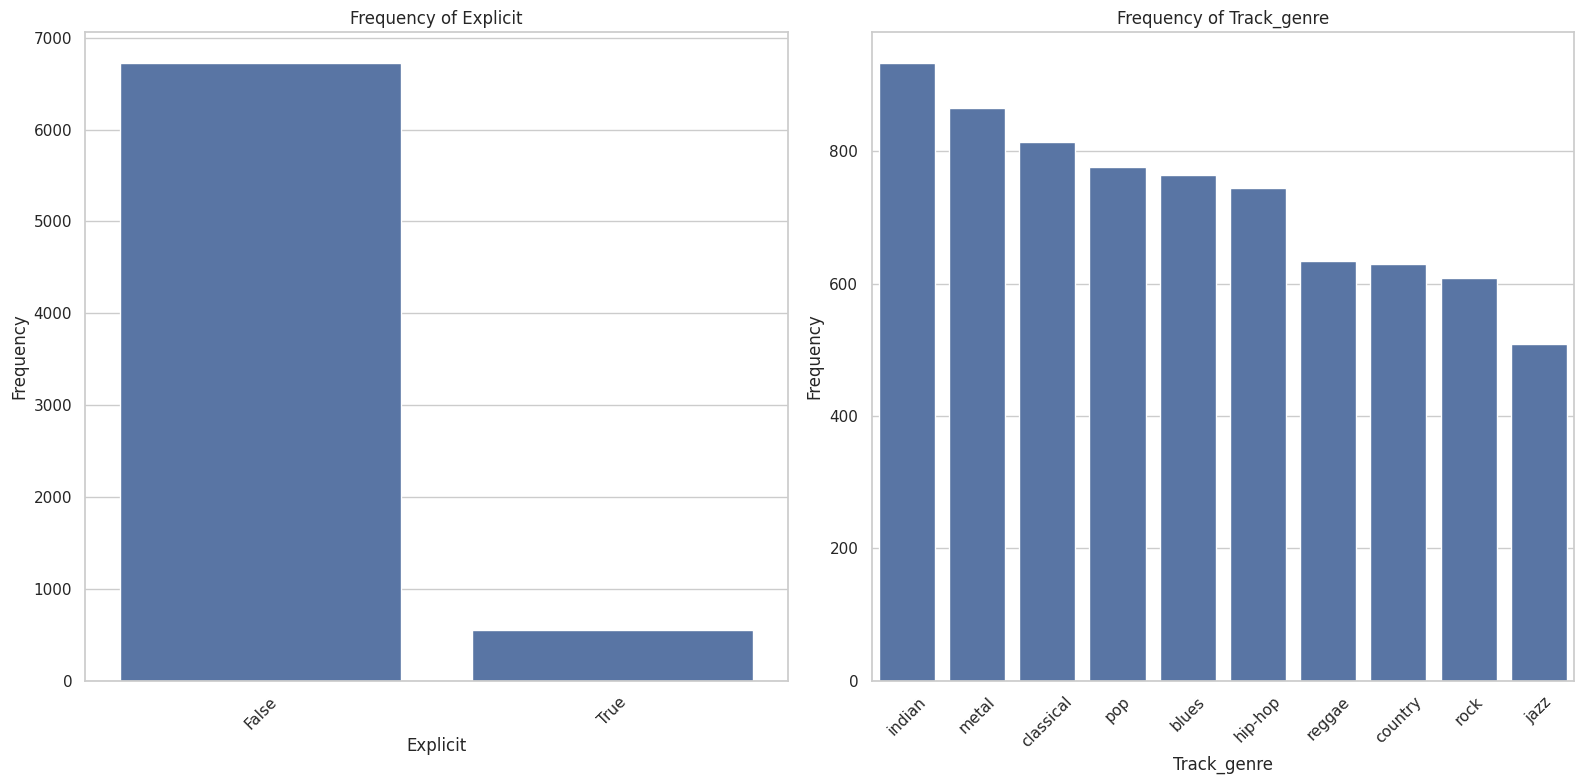

In [ ]:
# Set a theme for better aesthetics
sns.set_theme(style="whitegrid")

# Create a figure for qualitative features
fig_qual, axes_qual = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(16, 8)
)

# If there's only one qualitative feature, axes_qual might not be an array
if len(qualitative_features) == 1:
    axes_qual = [axes_qual]

# Bar plots for qualitative features
for i, feature in enumerate(qualitative_features):
    sns.countplot(data=data, x=feature, order=data[feature].value_counts().index, ax=axes_qual[i])
    axes_qual[i].set_title(f"Frequency of {feature.capitalize()}")
    axes_qual[i].set_xlabel(feature.capitalize())
    axes_qual[i].set_ylabel("Frequency")
    axes_qual[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

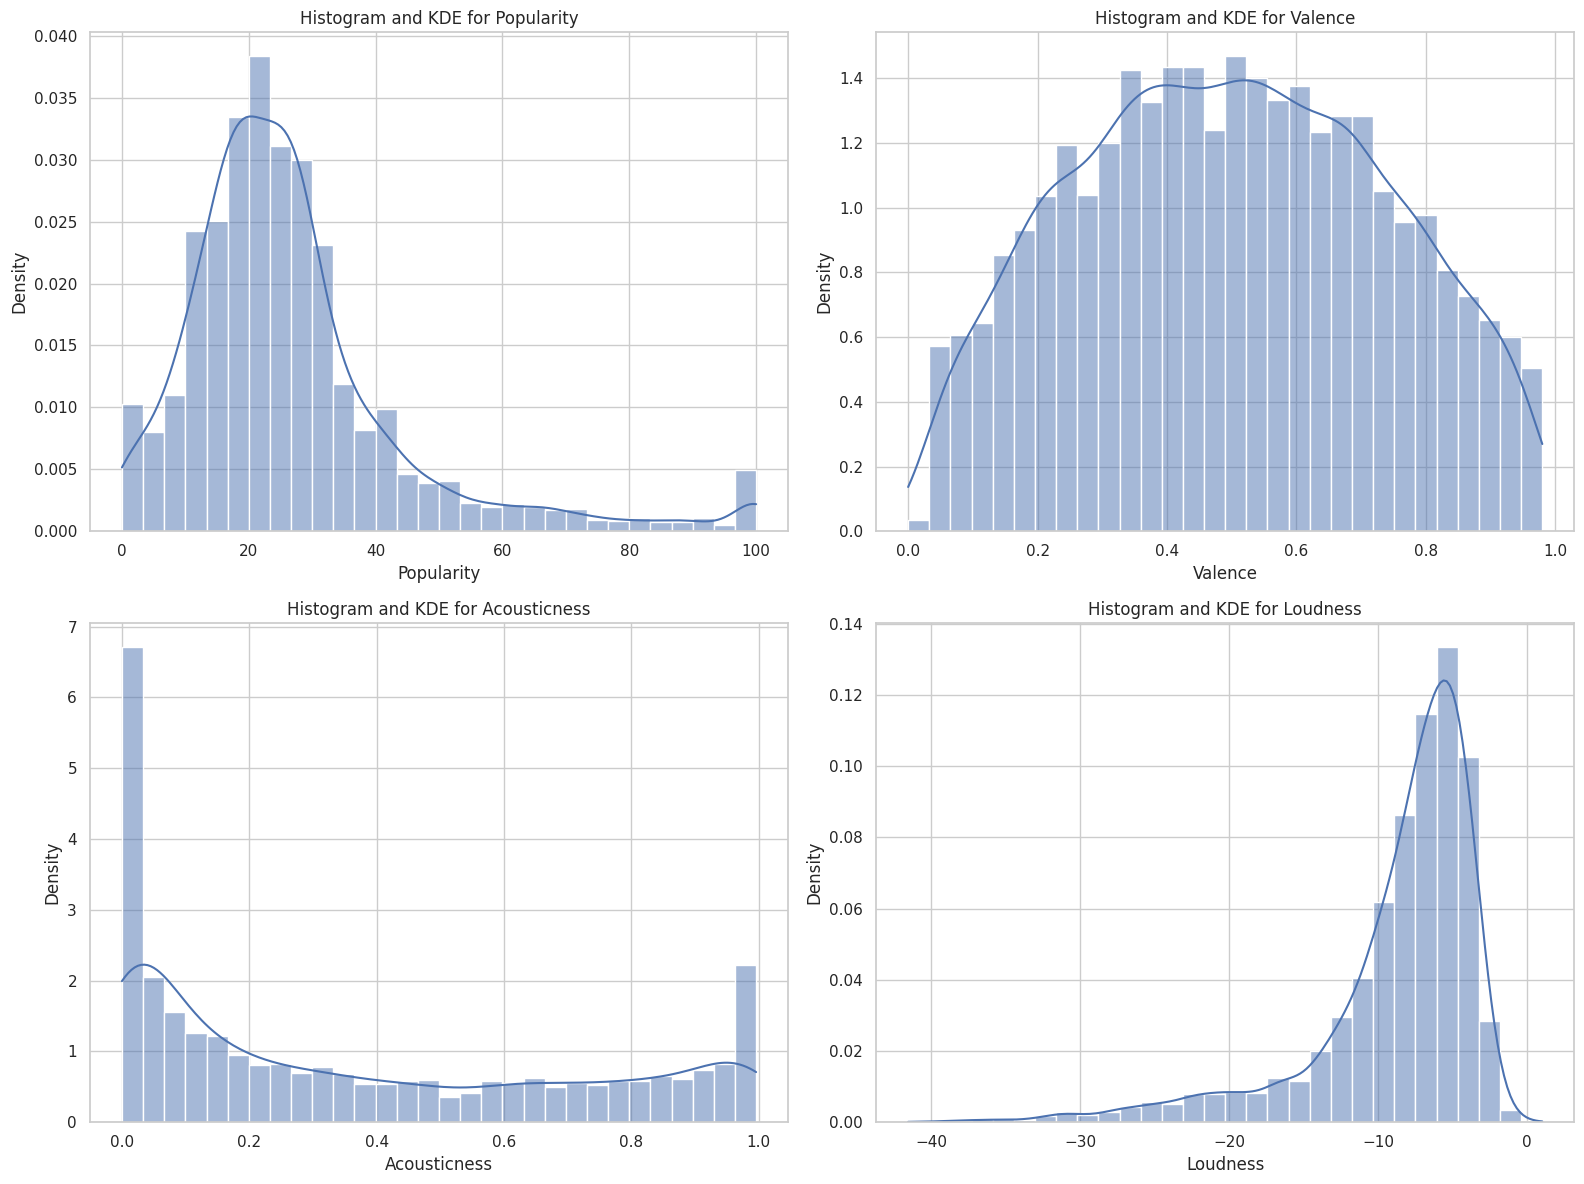

In [ ]:
# Create a figure for quantitative features with 2x2 layout
fig_quant, axes_quant = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(16, 12)
)

# Flatten the axes array for easier indexing
axes_quant = axes_quant.flatten()

# Histogram density plots with KDE for quantitative features
for i, feature in enumerate(quantitative_features):
    sns.histplot(data=data, x=feature, kde=True, stat="density", bins=30, ax=axes_quant[i])
    axes_quant[i].set_title(f"Histogram and KDE for {feature.capitalize()}")
    axes_quant[i].set_xlabel(feature.capitalize())
    axes_quant[i].set_ylabel("Density")

# Remove any unused axes
for i in range(len(quantitative_features), len(axes_quant)):
    fig_quant.delaxes(axes_quant[i])

plt.tight_layout()
plt.show()

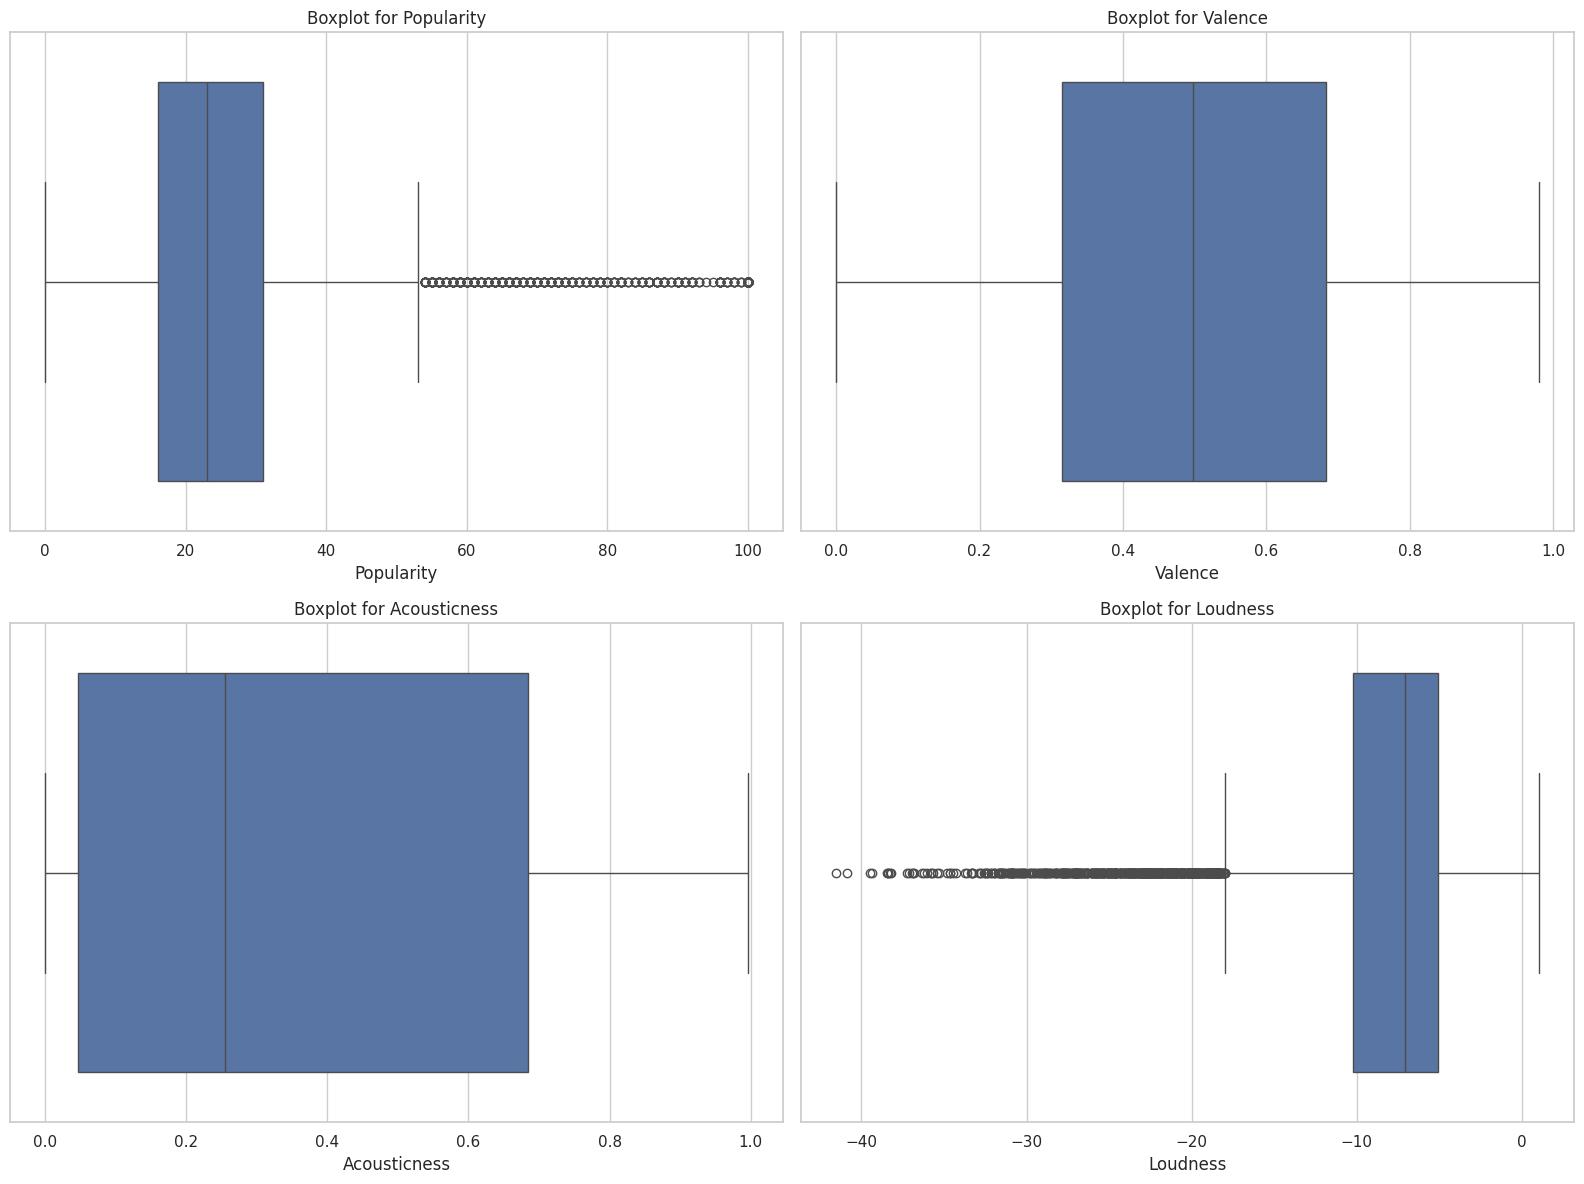

In [ ]:
# Create a separate figure for boxplots of quantitative features
fig_box, axes_box = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(16, 12)
)

# Flatten the axes array for easier iteration
axes_box = axes_box.flatten()

# Boxplots for quantitative features
for i, feature in enumerate(quantitative_features):
    sns.boxplot(data=data, x=feature, ax=axes_box[i])
    axes_box[i].set_title(f"Boxplot for {feature.capitalize()}")
    axes_box[i].set_xlabel(feature.capitalize())

# Remove unused axes if the grid is larger than the number of features
for i in range(len(quantitative_features), len(axes_box)):
    fig_box.delaxes(axes_box[i])

plt.tight_layout()
plt.show()


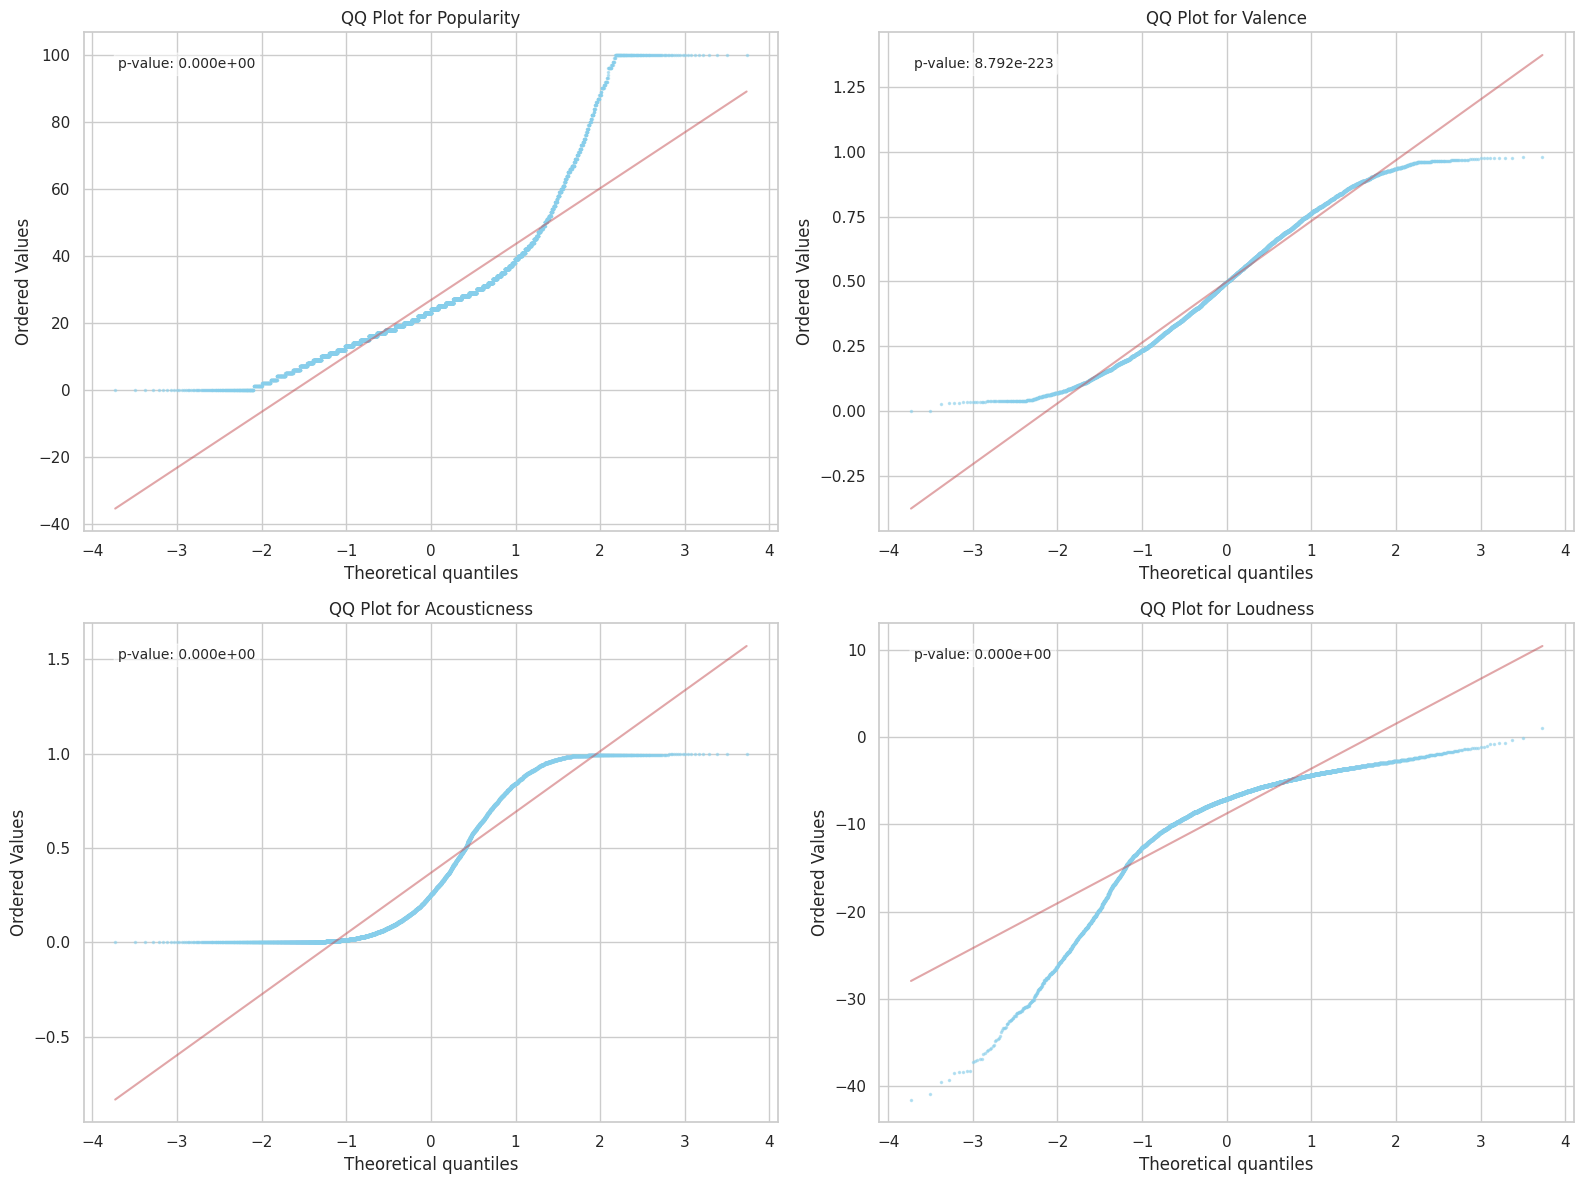

In [ ]:
# QQ Plots and D'Agostino and Pearson Test for Normality
fig_qq, axes_qq = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(16, 12)
)

# Flatten the axes array for easier iteration
axes_qq = axes_qq.flatten()

for i, feature in enumerate(quantitative_features):
    # QQ plot
    stats.probplot(data[feature], dist="norm", plot=axes_qq[i])
    axes_qq[i].set_title(f"QQ Plot for {feature.capitalize()}")
    axes_qq[i].get_lines()[1].set_alpha(0.5)  # Keep the diagonal QQ plot line visible
    axes_qq[i].get_lines()[1].set_linewidth(1.5)  # Set a thinner line width

    # Modify the points (make them smaller)
    axes_qq[i].get_lines()[0].set_marker('o')  # Ensure points are circles
    axes_qq[i].get_lines()[0].set_markersize(1.5)  # Make points smaller
    axes_qq[i].get_lines()[0].set_alpha(0.5)  # Set transparency
    axes_qq[i].get_lines()[0].set_color('skyblue') # Set color


    # Perform D'Agostino and Pearson test
    stat, p_value = normaltest(data[feature].dropna())
    axes_qq[i].text(0.05, 0.95, f"p-value: {p_value:.3e}",
                    transform=axes_qq[i].transAxes,
                    fontsize=10, verticalalignment='top',
                    bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))

# Remove unused axes if the grid is larger than the number of features
for i in range(len(quantitative_features), len(axes_qq)):
    fig_qq.delaxes(axes_qq[i])

plt.tight_layout()
plt.show()

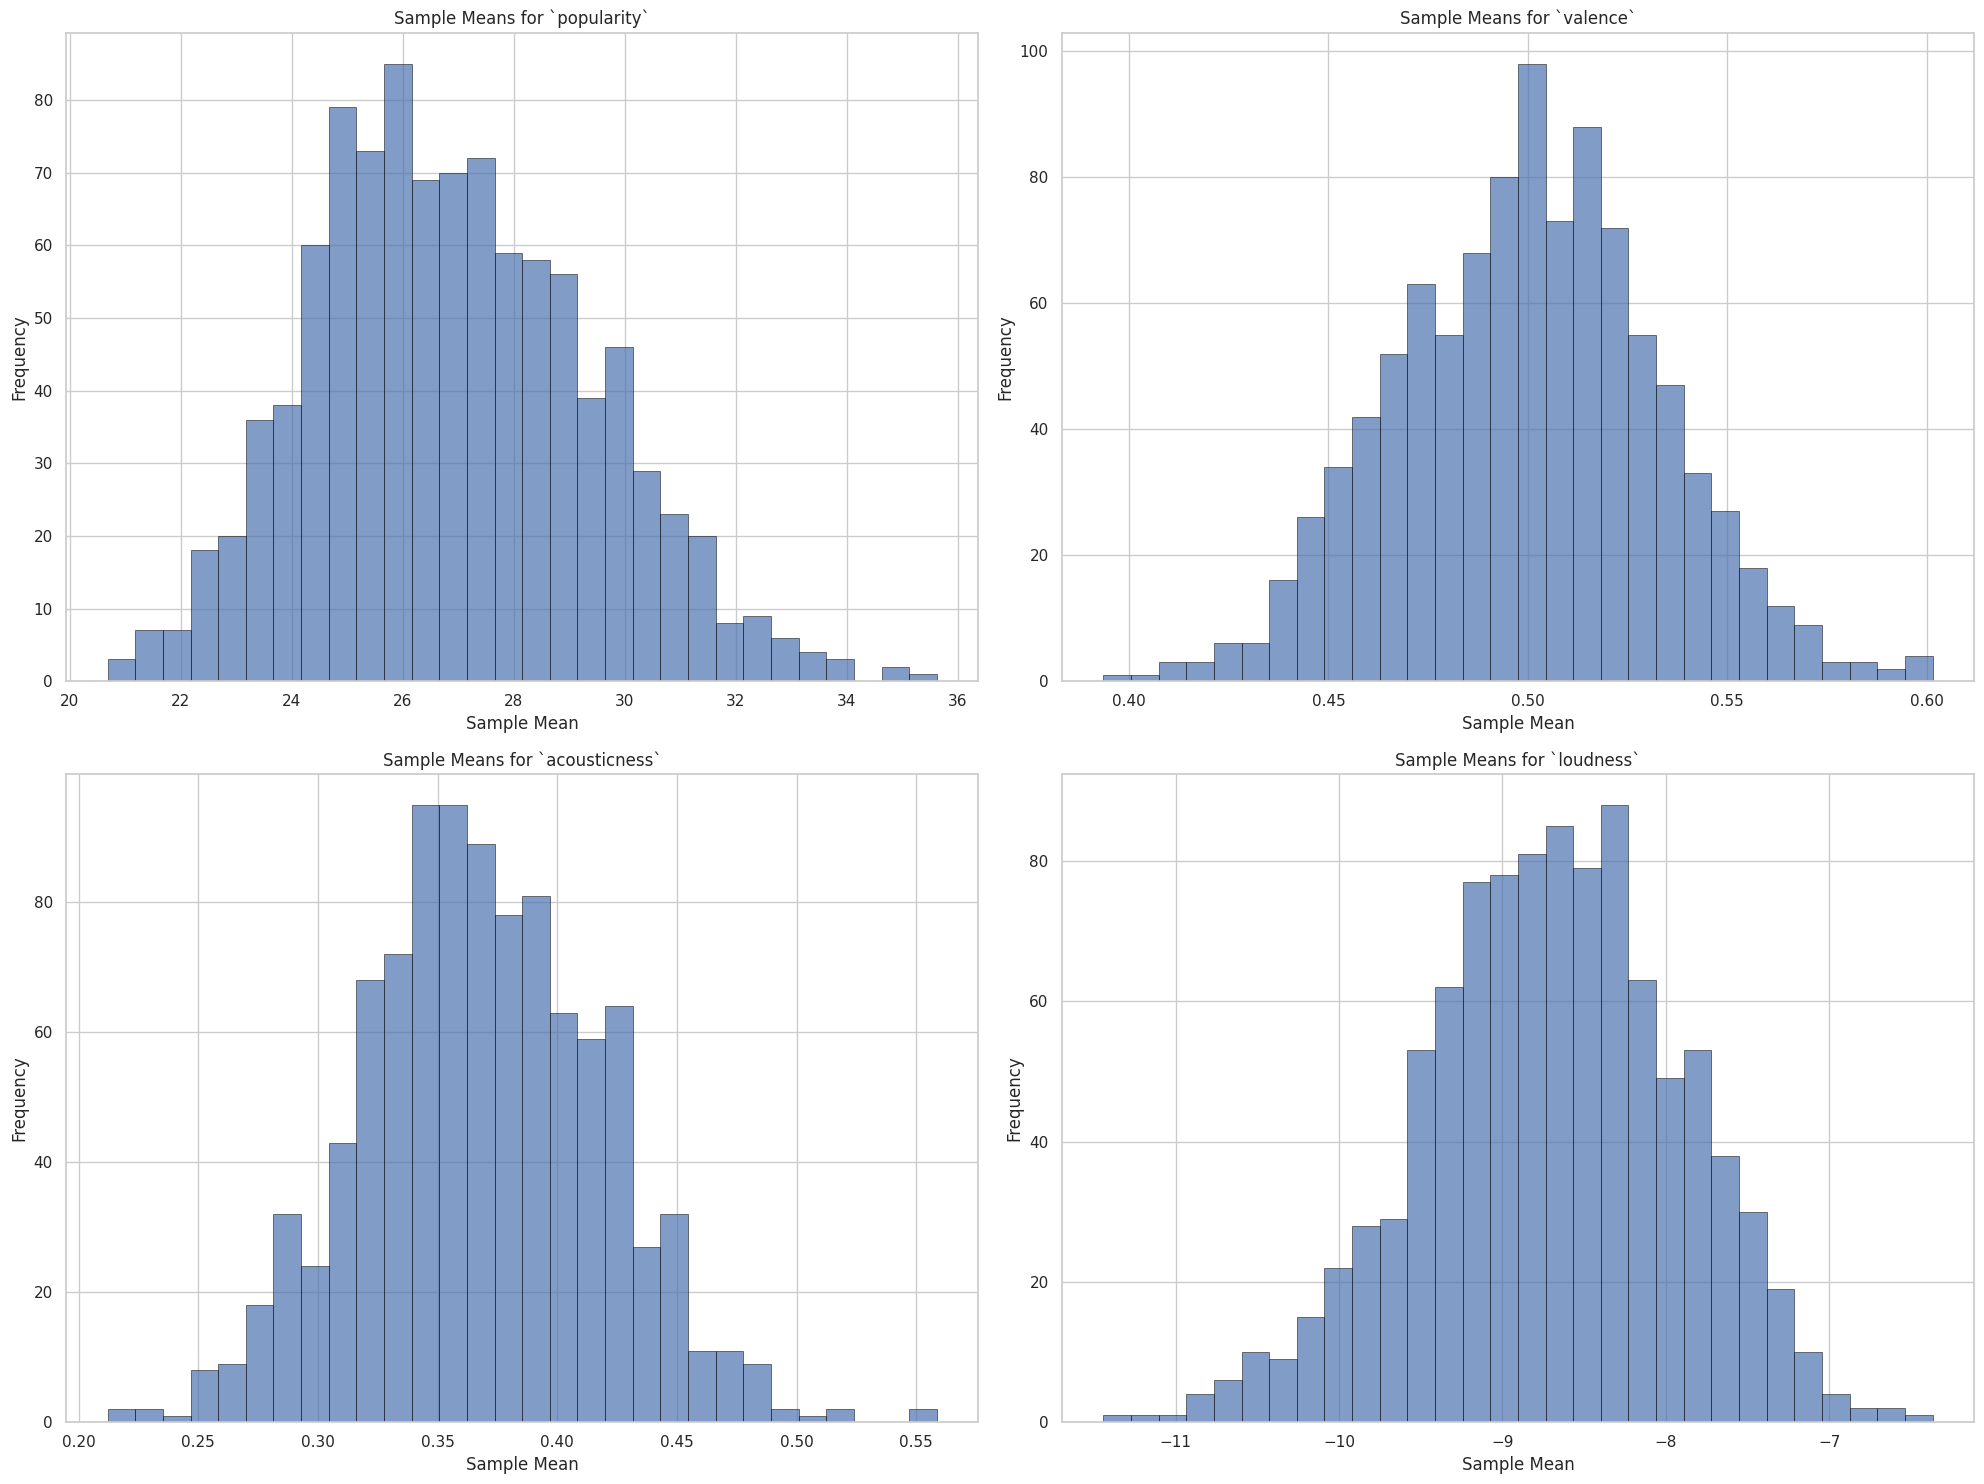

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot sampling distribution
def plot_sampling_distribution(ax, column_data, sample_size, num_samples, column_name):
    # Initialize an empty array to store sample means
    sample_means = []

    # Generate sampling distribution of sample means
    for _ in range(num_samples):
        sample = np.random.choice(column_data, sample_size, replace=True)
        sample_mean = np.mean(sample)
        sample_means.append(sample_mean)

    # Plotting the histogram of sample means
    ax.hist(sample_means, bins=30, alpha=0.7, edgecolor="black", linewidth=0.5)
    ax.set_title(f'Sample Means for `{column_name}`')
    ax.set_xlabel('Sample Mean')
    ax.set_ylabel('Frequency')

# Prepare to analyze selected columns
columns_to_analyze = quantitative_features

sample_size = 50
num_samples = 1000

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 15))

for i, column in enumerate(columns_to_analyze):
    row = i // 2
    col = i % 2
    try:
        # Get the data for the column, drop NaN values
        column_data = data[column].dropna().values
        plot_sampling_distribution(axs[row, col], column_data, sample_size, num_samples, column_name=column)
    except KeyError:
        axs[row, col].set_visible(False)
        print(f"Column '{column}' not found in the dataset.")

# Hide unused subplots if any
for j in range(len(columns_to_analyze), axs.size):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.savefig("Sample Means Plots.png", dpi=200)
plt.show()

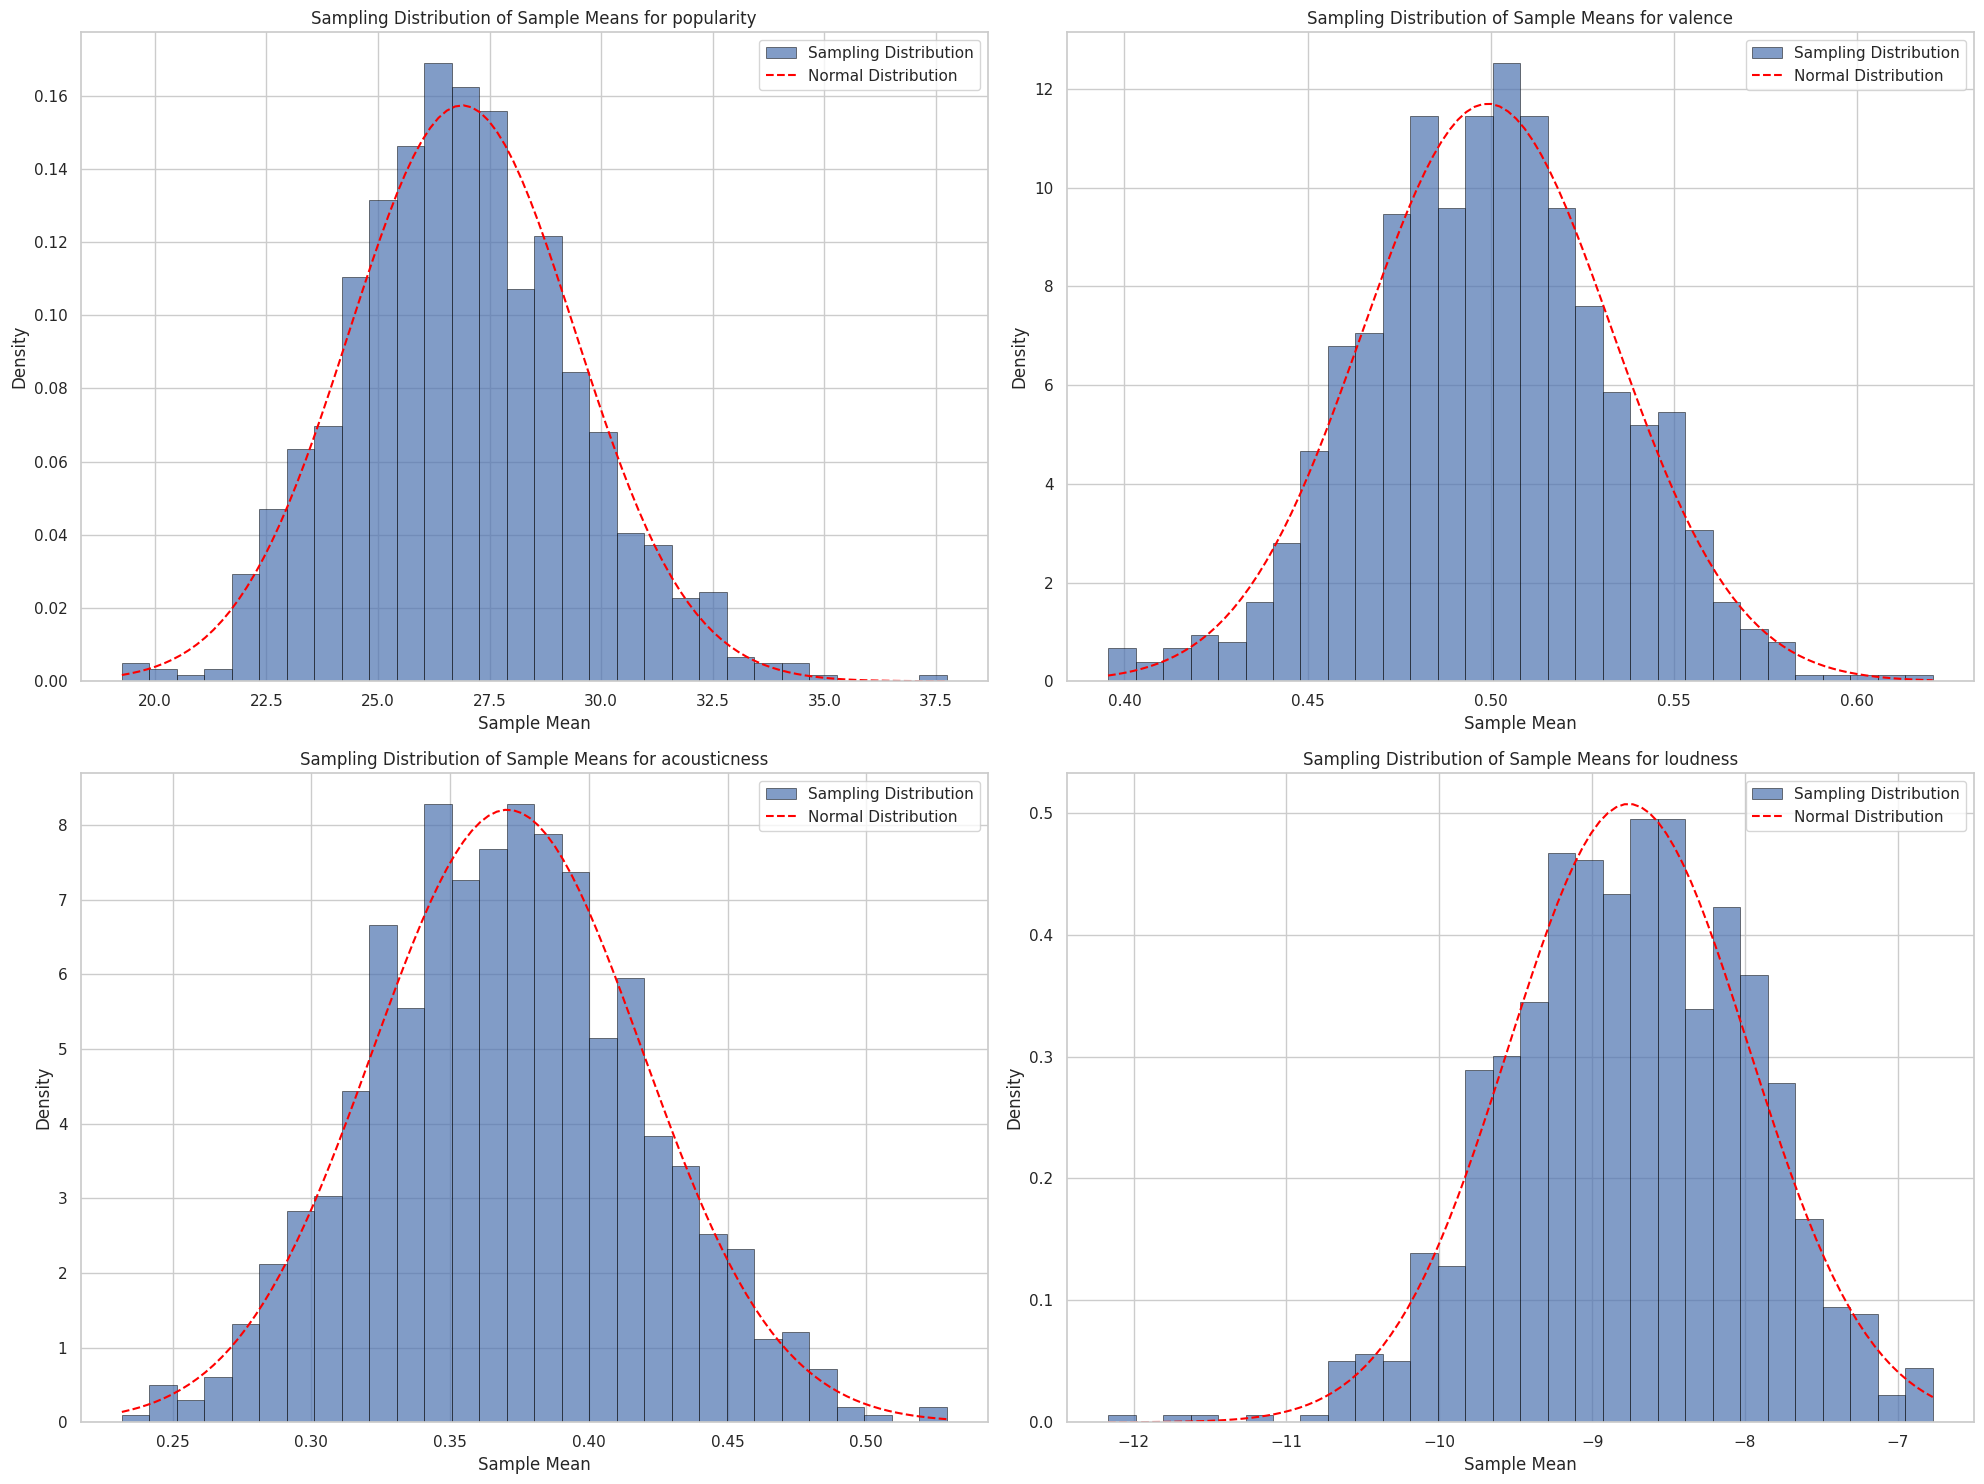

In [ ]:
from scipy.stats import norm

# Adjusted and corrected function
def plot_sampling_distribution(ax, data, sample_size, num_samples, column_name):
    # Initialize an empty array to store sample means
    sample_means = []

    # Generate sampling distribution of sample means
    for _ in range(num_samples):
        sample = np.random.choice(data, sample_size, replace=True)
        sample_mean = np.mean(sample)
        sample_means.append(sample_mean)

    # Plotting the histogram of sample means
    ax.hist(sample_means, bins=30, density=True, alpha=0.7, edgecolor="black", linewidth=0.5, label='Sampling Distribution')

    # Calculate mean and standard deviation of the sampling distribution
    sampling_mean = np.mean(sample_means)
    sampling_std = np.std(sample_means)

    # Plotting the normal distribution curve
    x = np.linspace(min(sample_means), max(sample_means), 100)
    y = norm.pdf(x, sampling_mean, sampling_std)
    ax.plot(x, y, color='red', linestyle='--', label='Normal Distribution')

    ax.set_title(f'Sampling Distribution of Sample Means for {column_name}')
    ax.set_xlabel('Sample Mean')
    ax.set_ylabel('Density')
    ax.legend()

# Prepare to analyze selected columns
columns_to_analyze = quantitative_features

# Sampling parameters
sample_size = 50
num_samples = 1000

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 15))  # Adjusted layout for more columns

for i, column in enumerate(columns_to_analyze):
    row = i // 2
    col = i % 2
    try:
        # Ensure the column is numeric and drop NaN values
        column_data = data[column].dropna().values
        plot_sampling_distribution(axs[row, col], column_data, sample_size, num_samples, column_name=column)
    except KeyError:
        print(f"Column '{column}' not found in the dataset.")
        fig.delaxes(axs[row, col])  # Remove the subplot if the column doesn't exist

# Hide unused subplots if any
for j in range(len(columns_to_analyze), axs.size):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.savefig("Sampling Distribution Plots.png", dpi=200)
plt.show()

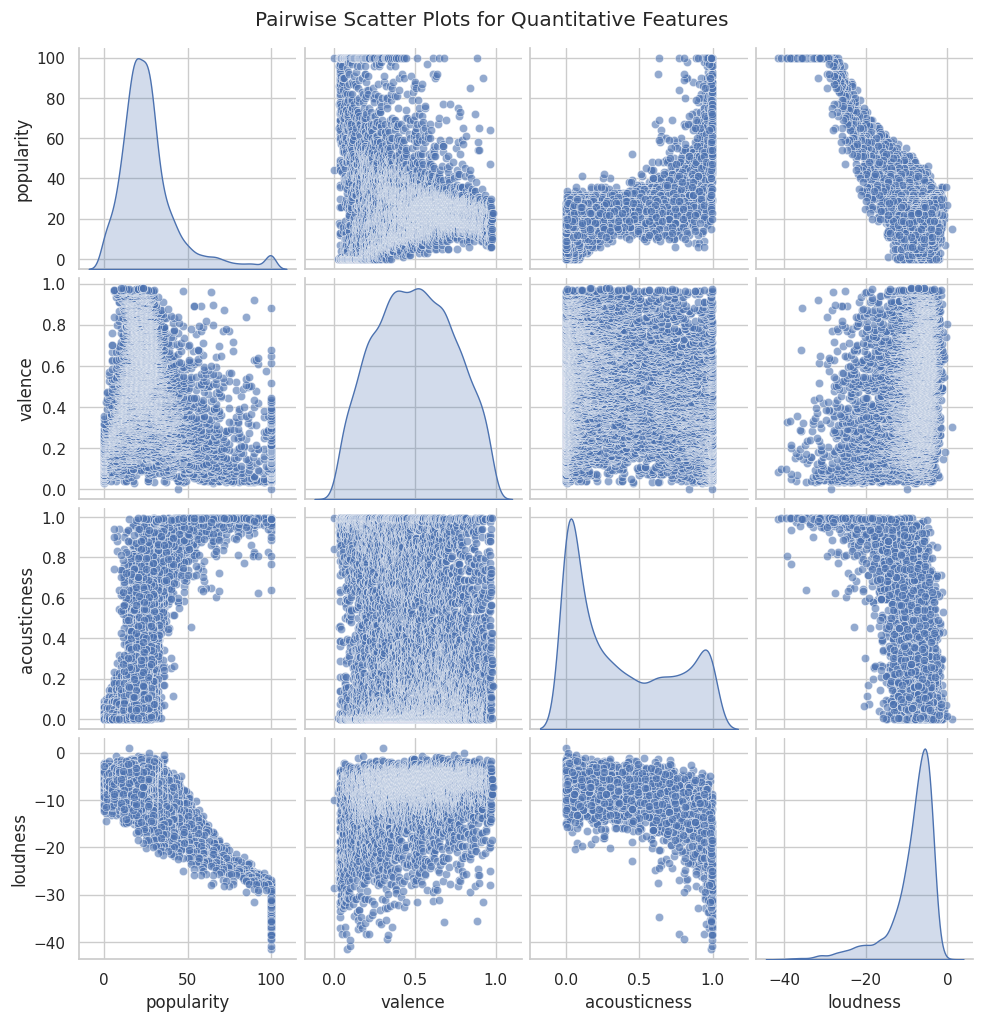

In [ ]:
# Pairwise scatter plots for quantitative features
sns.pairplot(data[quantitative_features], diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle("Pairwise Scatter Plots for Quantitative Features", y=1.02)
plt.show()

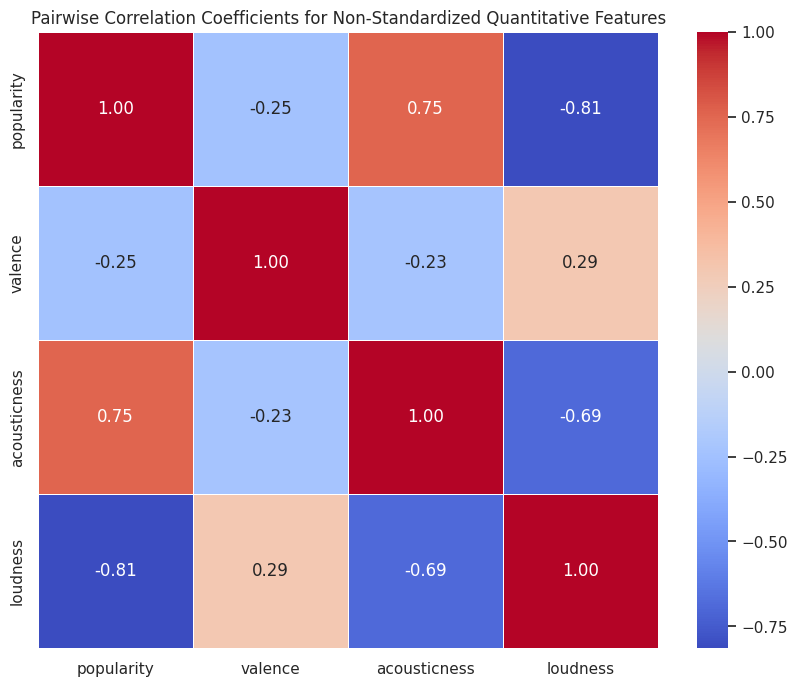

In [ ]:
# Calculate pairwise correlation coefficients for non-standardized data
correlation_matrix_non_standardized = data[quantitative_features].corr()

# Create a heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix_non_standardized,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5
)
plt.title("Pairwise Correlation Coefficients for Non-Standardized Quantitative Features")
plt.show()


In [ ]:
!pip install scikit-posthocs

In [ ]:
import scikit_posthocs as sp
import pandas as pd

# Assuming 'popularity' is the variable and 'genre' is the grouping factor
# Perform Kruskal-Wallis test first
from scipy.stats import kruskal

genre_groups = [data[data['track_genre'] == genre]['popularity'].dropna() for genre in data['track_genre'].unique()]
h_statistic, p_value = kruskal(*genre_groups)

if p_value < 0.05:
    print(f"Kruskal-Wallis test indicates a significant difference. H-Stat value is {h_statistic} and p-value is {p_value}. Proceeding with Dunn's test.")
    dunn_results = sp.posthoc_dunn(data, val_col='popularity', group_col='track_genre', p_adjust='bonferroni')
else:
    print("No significant difference between groups found, no need for post-hoc test.")

dunn_results

Kruskal-Wallis test indicates a significant difference. H-Stat value is 4245.986543268715 and p-value is 0.0. Proceeding with Dunn's test.


,blues,classical,country,hip-hop,indian,jazz,metal,pop,reggae,rock
blues,1.000000e+00,1.848131e-263,6.808430e-73,1.362498e-01,1.487695e-35,5.194249e-152,1.183627e-58,2.365465e-67,4.011706e-68,1.294095e-02
classical,1.848131e-263,1.000000e+00,5.901944e-46,3.070709e-307,3.749192e-121,8.741643e-04,0.000000e+00,8.019823e-64,2.483674e-50,2.073254e-183
country,6.808430e-73,5.901944e-46,1.000000e+00,4.199904e-96,1.117102e-10,3.747483e-17,3.484048e-256,1.000000e+00,1.000000e+00,8.052407e-42
hip-hop,1.362498e-01,3.070709e-307,4.199904e-96,1.000000e+00,2.473432e-54,2.417433e-182,3.204764e-38,4.840102e-91,1.096565e-90,7.029488e-09
indian,1.487695e-35,3.749192e-121,1.117102e-10,2.473432e-54,1.000000e+00,6.793054e-57,1.824285e-201,8.708253e-07,9.806760e-09,1.631805e-14
jazz,5.194249e-152,8.741643e-04,3.747483e-17,2.417433e-182,6.793054e-57,1.000000e+00,0.000000e+00,1.542984e-25,1.569908e-19,2.376469e-104
metal,1.183627e-58,0.000000e+00,3.484048e-256,3.204764e-38,1.824285e-201,0.000000e+00,1.000000e+00,6.248144e-260,2.267869e-247,1.338246e-79
pop,2.365465e-67,8.019823e-64,1.000000e+00,4.840102e-91,8.708253e-07,1.542984e-25,6.248144e-260,1.000000e+00,1.000000e+00,2.534208e-36
reggae,4.011706e-68,2.483674e-50,1.000000e+00,1.096565e-90,9.806760e-09,1.569908e-19,2.267869e-247,1.000000e+00,1.000000e+00,2.320001e-38
rock,1.294095e-02,2.073254e-183,8.052407e-42,7.029488e-09,1.631805e-14,2.376469e-104,1.338246e-79,2.534208e-36,2.320001e-38,1.000000e+00


In [ ]:
# Perform Mann-Whitney U Test
explicit_0 = data[data['explicit'] == False]['popularity']
explicit_1 = data[data['explicit'] == True]['popularity']

# Mann-Whitney U test
stat, p_value = stats.mannwhitneyu(explicit_0, explicit_1, alternative="two-sided")

# Print the results
print("Mann-Whitney U Test Results")
print(f"U statistic: {stat}")
print(f"p-value: {p_value:.5f}")

# Interpretation
if p_value < 0.05:
    print("Reject the null hypothesis: 'popularity' is likely dependent on 'explicit'.")
else:
    print("Fail to reject the null hypothesis: 'popularity' is not significantly dependent on 'explicit'.")

Mann-Whitney U Test Results
U statistic: 2980323.5
p-value: 0.00000
Reject the null hypothesis: 'popularity' is likely dependent on 'explicit'.


In [ ]:
# Comparison of mean and standard deviation of popularity across track genres and explicit
popularity_summary = data.groupby(["track_genre", "explicit"])['popularity'].agg(['mean', 'std']).reset_index()

print("\nMean and Standard Deviation of Popularity")
print(popularity_summary)


Mean and Standard Deviation of Popularity
   track_genre  explicit       mean        std
0        blues     False  18.937333   9.449186
1        blues      True  13.928571   3.892088
2    classical     False  58.538084  26.348416
3      country     False  29.206667   7.933401
4      country      True  19.600000   7.600363
5      hip-hop     False  18.549372   4.996382
6      hip-hop      True  11.132979   6.125984
7       indian     False  25.639254  10.507972
8       indian      True  19.333333  11.078508
9         jazz     False  40.444664  15.742416
10        jazz      True  21.333333   1.527525
11       metal     False   9.082544   5.323666
12       metal      True   4.377953   4.005808
13         pop     False  28.211405   7.689289
14         pop      True  19.807018   6.906101
15      reggae     False  27.818182   3.702955
16      reggae      True  21.869048   4.676987
17        rock     False  21.008681   7.725616
18        rock      True  12.593750   6.009988


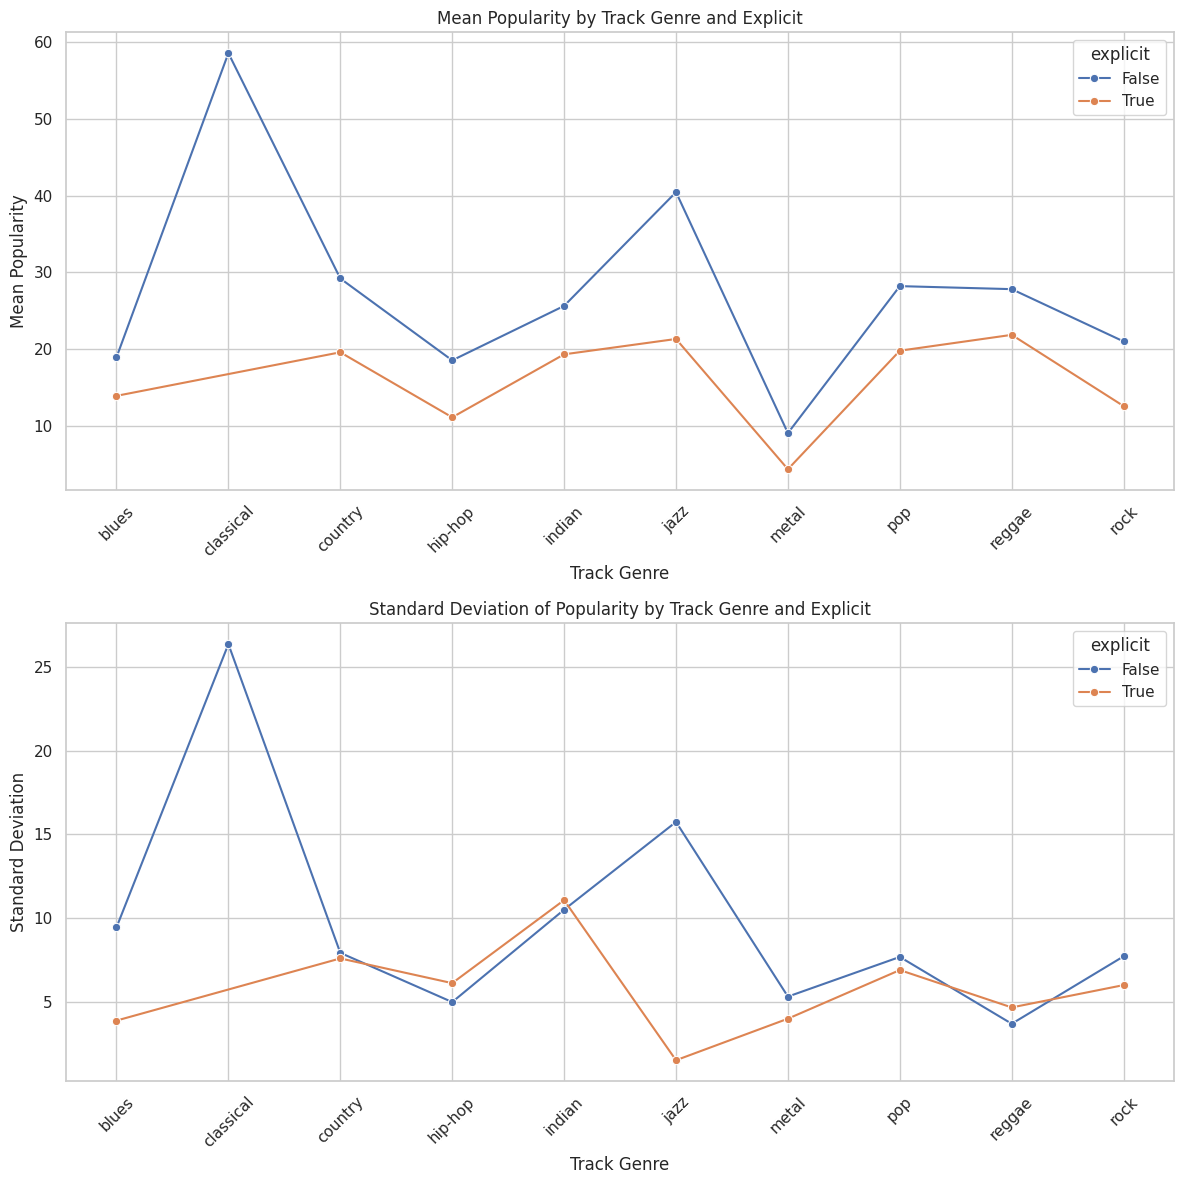

<ipython-input-79-6a2a38db988e>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x="track_genre", y="popularity", palette="Set3")


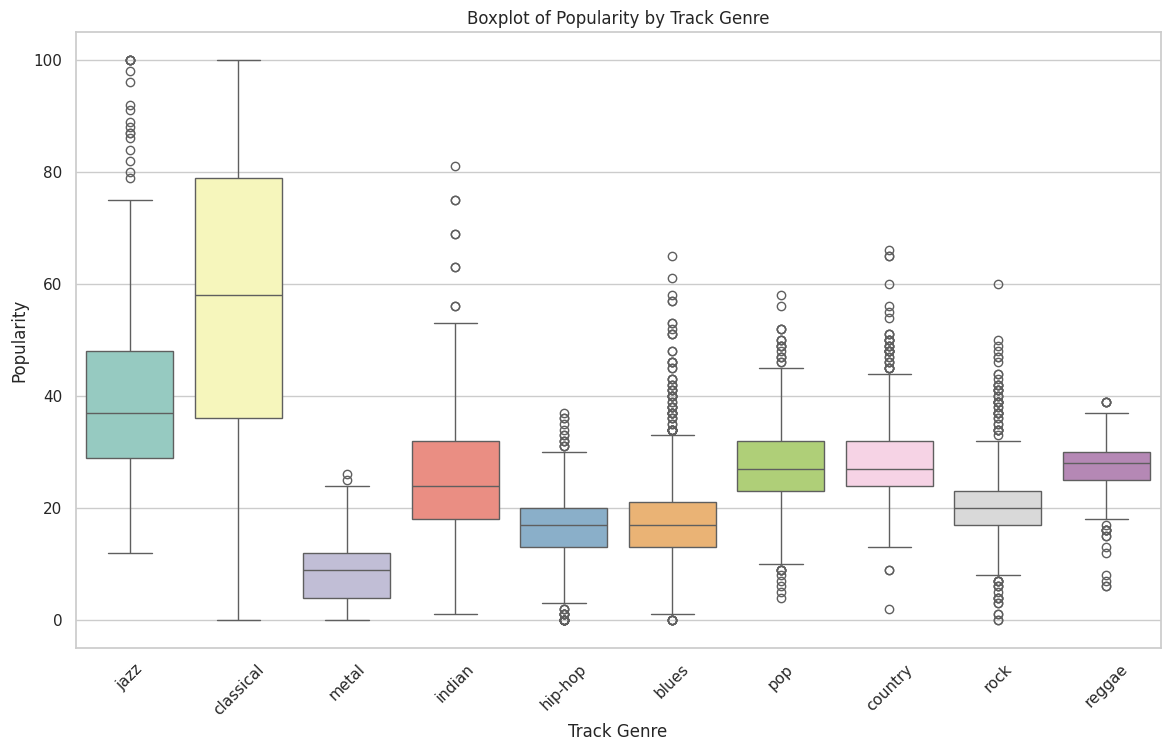

<ipython-input-79-6a2a38db988e>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x="explicit", y="popularity", palette="Set2")


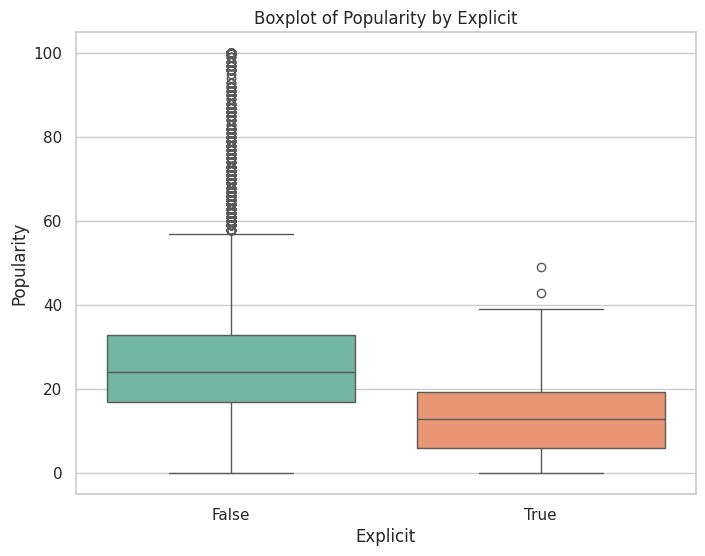

In [ ]:
# Line charts for mean and standard deviation of popularity by track_genre
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Line chart for mean
sns.lineplot(data=popularity_summary, x="track_genre", y="mean", hue="explicit", marker="o", ax=axes[0])
axes[0].set_title("Mean Popularity by Track Genre and Explicit")
axes[0].set_xlabel("Track Genre")
axes[0].set_ylabel("Mean Popularity")
axes[0].tick_params(axis='x', rotation=45)

# Line chart for standard deviation
sns.lineplot(data=popularity_summary, x="track_genre", y="std", hue="explicit", marker="o", ax=axes[1])
axes[1].set_title("Standard Deviation of Popularity by Track Genre and Explicit")
axes[1].set_xlabel("Track Genre")
axes[1].set_ylabel("Standard Deviation")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Boxplot for popularity by track_genre
plt.figure(figsize=(14, 8))
sns.boxplot(data=data, x="track_genre", y="popularity", palette="Set3")
plt.title("Boxplot of Popularity by Track Genre")
plt.xlabel("Track Genre")
plt.ylabel("Popularity")
plt.xticks(rotation=45)
plt.show()

# Boxplot for popularity by explicit
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x="explicit", y="popularity", palette="Set2")
plt.title("Boxplot of Popularity by Explicit")
plt.xlabel("Explicit")
plt.ylabel("Popularity")
plt.show()


In [ ]:
# Contingency table for explicit and track_genre
contingency_table = pd.crosstab(data["explicit"], data["track_genre"])
print(tabulate(contingency_table, headers='keys', tablefmt='psql'))


# Perform Chi-Square test
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print("Chi-Square Test for Independence Between Explicit and Track Genre")
print(f"Chi-Square Statistic: {chi2_stat:.4f}")
print(f"Degrees of Freedom: {dof}")
print(f"P-value: {p_value:.4e}")

# Interpretation
if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant association between Explicit and Track Genre.")
else:
    print("Fail to reject the null hypothesis: No significant association between Explicit and Track Genre.")

+------------+---------+-------------+-----------+-----------+----------+--------+---------+-------+----------+--------+
| explicit   |   blues |   classical |   country |   hip-hop |   indian |   jazz |   metal |   pop |   reggae |   rock |
|------------+---------+-------------+-----------+-----------+----------+--------+---------+-------+----------+--------|
| False      |     750 |         814 |       600 |       557 |      912 |    506 |     739 |   719 |      550 |    576 |
| True       |      14 |           0 |        30 |       188 |       21 |      3 |     127 |    57 |       84 |     32 |
+------------+---------+-------------+-----------+-----------+----------+--------+---------+-------+----------+--------+
Chi-Square Test for Independence Between Explicit and Track Genre
Chi-Square Statistic: 606.2774
Degrees of Freedom: 9
P-value: 9.4114e-125
Reject the null hypothesis: There is a significant association between Explicit and Track Genre.


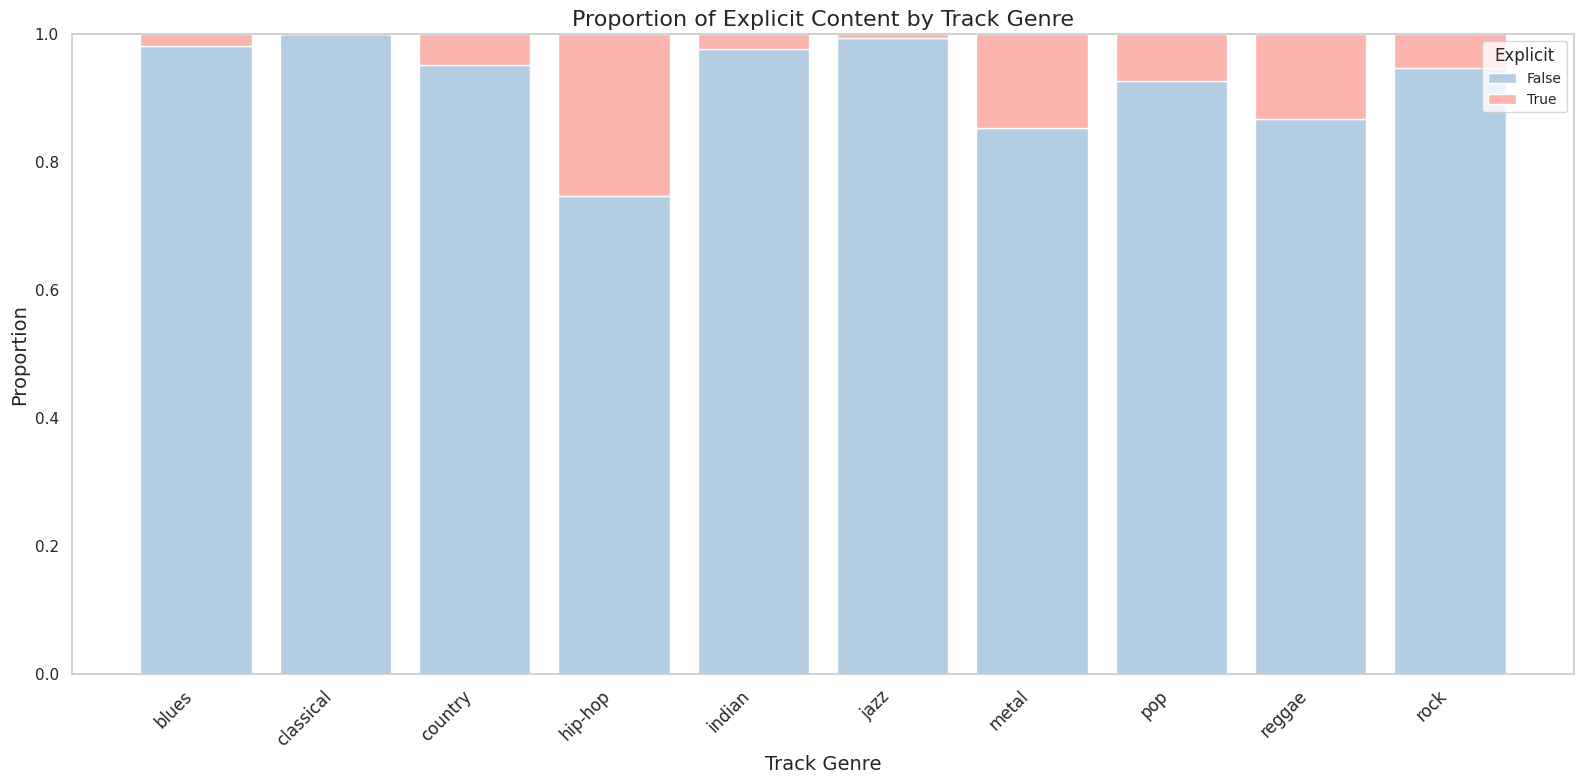

In [ ]:
# Assuming df is your DataFrame and the contingency table is created as follows:
contingency_table = pd.crosstab(data["track_genre"], data["explicit"])

# Normalize the contingency table by row to get proportions
contingency_table_normalized = contingency_table.div(contingency_table.sum(axis=1), axis=0)

# Define a custom color palette
custom_palette = sns.color_palette("Pastel1")

# Create the figure and axes
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the stacked bar chart
bottom = None
for i, column in enumerate(contingency_table_normalized.columns):
    if bottom is None:
        bottom = contingency_table_normalized[column]
        ax.bar(
            contingency_table_normalized.index,
            contingency_table_normalized[column],
            label=str(column),
            color=custom_palette[i+1],
        )
    else:
        ax.bar(
            contingency_table_normalized.index,
            contingency_table_normalized[column],
            bottom=bottom,
            label=str(column),
            color=custom_palette[i-1],
        )
        bottom += contingency_table_normalized[column]

# Add title and labels
ax.set_title("Proportion of Explicit Content by Track Genre", fontsize=16)
ax.set_xlabel("Track Genre", fontsize=14)
ax.set_ylabel("Proportion", fontsize=14)
ax.set_xticks(range(len(contingency_table_normalized.index)))
ax.set_xticklabels(contingency_table_normalized.index, rotation=45, ha="right", fontsize=12)
ax.legend(title="Explicit", title_fontsize=12, fontsize=10, loc="upper right", frameon=True)

# Add grid for better readability
# ax.grid(axis="y", linestyle="--", alpha=0.7)
ax.grid(False)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
df = data.copy()

In [ ]:
from sklearn.preprocessing import StandardScaler

# Selecting quantitative features
scaler = StandardScaler()
df[quantitative_features] = scaler.fit_transform(df[quantitative_features])

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["explicit"] = le.fit_transform(df["explicit"])  # True -> 1, False -> 0
df["track_genre"] = le.fit_transform(df["track_genre"])  # Encode track_genre

In [ ]:
# df = pd.get_dummies(data, columns=["track_genre"], drop_first=True)

In [ ]:
df

,valence,acousticness,explicit,track_genre,loudness,popularity
0,-2.102490,1.366821,0,5,-0.202840,0.943047
1,-2.102490,1.808794,0,1,-3.444470,4.017063
2,-1.987317,-1.053145,0,6,0.094407,-1.472251
3,-1.981833,1.609473,0,1,-2.100056,2.095803
4,-1.977192,0.248887,0,1,0.177266,-0.484174
...,...,...,...,...,...,...
7274,2.019270,-0.271083,0,2,-0.008164,-0.264602
7275,2.019270,-0.224863,0,2,0.545860,-0.264602
7276,2.023488,0.168003,0,0,0.548302,-0.923319
7277,2.027707,-0.580175,0,5,0.263091,-0.209709


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Split data into features and target
X = df.drop("popularity", axis=1)  # Independent variables
y = df["popularity"]  # Dependent variable (target)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 82.83180328438291
R-squared: 0.7683825694307859


In [ ]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Intercept:", model.intercept_)
print("Training set: MSE =", train_mse, "R2 =", train_r2)
print("Test set: MSE =", test_mse, "R2 =", test_r2)
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))

Intercept: 0.36520802324425006
Training set: MSE = 82.7451119666578 R2 = 0.7457226121123051
Test set: MSE = 82.83180328438291 R2 = 0.7683825694307859
Coefficient of determination: 0.77


In [ ]:
model.score(X_train, y_train)

0.7457226121123051

In [ ]:
#import statsmodels.api as sm

# Add a constant to the features matrix
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Fit the model
model_sm = sm.OLS(y_train, X_train_sm).fit()

# Summary of the model
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     3412.
Date:                Mon, 09 Dec 2024   Prob (F-statistic):               0.00
Time:                        01:08:06   Log-Likelihood:                -21119.
No. Observations:                5823   AIC:                         4.225e+04
Df Residuals:                    5817   BIC:                         4.229e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.3652      0.492      0.742   

In [ ]:
# Fit the model with statsmodels to access additional statistics
X_train_sm = sm.add_constant(X_train)
model_sm = sm.OLS(y_train, X_train_sm).fit()

# Calculate correlation between features and target variable
correlation = X_train.corrwith(y_train)

# Extract coefficients, standard errors, and p-values
coefficients = model_sm.params
std_errors = model_sm.bse
p_values = model_sm.pvalues

# Create a DataFrame for the summary table
summary_table = pd.DataFrame({
    'Feature': list(X_train.columns),
    'Correlation(R)': correlation.values,
    'Coefficient': coefficients[1:],  # Exclude the intercept coefficient
    'Standard Error': std_errors[1:],  # Exclude the intercept standard error
    'P-value': p_values[1:]  # Exclude the intercept p-value
})

# Convert DataFrame to tabular form
table = tabulate(summary_table, headers='keys', tablefmt='pretty', showindex=False)

# Display the table
print(table)

+--------------+----------------------+---------------------+----------------------+------------------------+
|   Feature    |    Correlation(R)    |     Coefficient     |    Standard Error    |        P-value         |
+--------------+----------------------+---------------------+----------------------+------------------------+
|   valence    | -0.24648526409656174 | 0.21691735113776034 |  0.5277155797485821  |   0.681051205325663    |
| acousticness |  0.7526368833585012  | 19.773948513416997  | 0.48136536800593677  |          0.0           |
|   explicit   | -0.21269809729643324 | -4.9838650341318225 | 0.45889557501329564  | 3.236835166120322e-27  |
| track_genre  | -0.2343538480784511  | 0.7437670699368508  | 0.046011547234688546 | 1.5777720010632044e-57 |
|   loudness   | -0.8093366535456763  | -1.8496196268534986 |  0.029934727495406   |          0.0           |
+--------------+----------------------+---------------------+----------------------+------------------------+


In [ ]:
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print model performance
print("Mean Squared Error:", mse)
print("R-squared (Test):", r2)

# Print training accuracy (R-squared for training data)
train_r2 = model.score(X_train, y_train)
print("R-squared (Train):", train_r2)

# Print the coefficients for each feature
coefficients = model.coef_
features = X.columns

# Create a DataFrame to view the coefficients for each feature
coef_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": coefficients
})

# Convert DataFrame to tabular form
table = tabulate(coef_df, headers='keys', tablefmt='pretty', showindex=False)

# Display the table
print(table)

Mean Squared Error: 82.83180328438291
R-squared (Test): 0.7683825694307859
R-squared (Train): 0.7457226121123051
+--------------+---------------------+
|   Feature    |     Coefficient     |
+--------------+---------------------+
|   valence    | 0.21691735113772947 |
| acousticness | 19.773948513416926  |
|   explicit   | -4.9838650341317985 |
| track_genre  | 0.7437670699368559  |
|   loudness   | -1.849619626853496  |
+--------------+---------------------+


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Assuming df is your dataset after pre-processing

# Split data into features and target
X = df.drop("popularity", axis=1)  # Independent variables
y = df["popularity"]  # Dependent variable (target)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Predictions
y_pred = dt_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))

print("Mean Squared Error:", mse)
print("R-squared:", r2)

# To view the feature importance
print("Feature importances:", dt_model.feature_importances_)

Coefficient of determination: 0.97
Mean Squared Error: 0.027402835844058136
R-squared: 0.9745707510319441
Feature importances: [0.0929928  0.21465103 0.00526677 0.05117926 0.63591013]


In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Split data into features and target
X = df.drop("popularity", axis=1)  # Independent variables
y = df["popularity"]  # Dependent variable (target)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the SVR model
svr_model = SVR(kernel='rbf')  # You can also experiment with different kernels: 'linear', 'poly', etc.
svr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred = svr_model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)


Mean Squared Error: 0.02677581772417499
R-squared: 0.9751526105142521


In [ ]:
# Coefficients (dual coefficients in SVR)
coefficients = svr_model.dual_coef_[0]

# Intercept
intercept = svr_model.intercept_

# Create a DataFrame for the summary table
summary_table = pd.DataFrame({
    'Feature': list(X_train.columns),
    'Coefficient': coefficients[0],  # Coefficients (dual coefficients)
    'Intercept': [intercept] * len(X_train.columns)  # Same intercept for all features
})

# Convert DataFrame to tabular form
table = tabulate(summary_table, headers='keys', tablefmt='pretty', showindex=False)

# Display the table
print(table)

+--------------+-------------+---------------+
|   Feature    | Coefficient |   Intercept   |
+--------------+-------------+---------------+
|   valence    |    -1.0     | [-0.11924744] |
| acousticness |    -1.0     | [-0.11924744] |
|   explicit   |    -1.0     | [-0.11924744] |
| track_genre  |    -1.0     | [-0.11924744] |
|   loudness   |    -1.0     | [-0.11924744] |
+--------------+-------------+---------------+


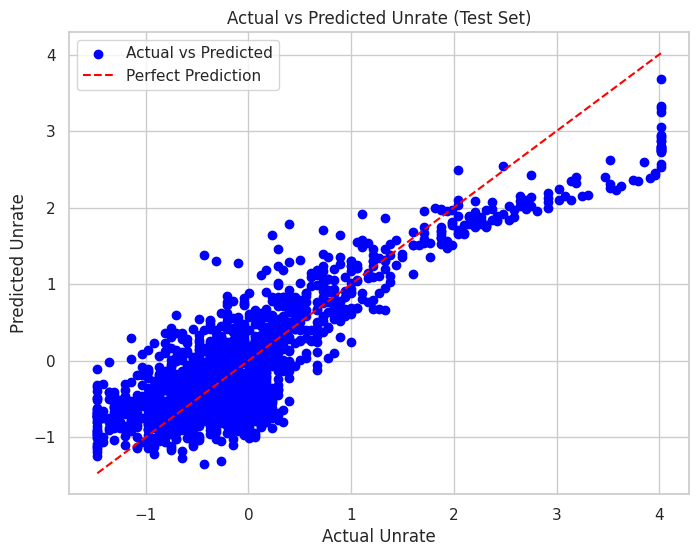

In [ ]:
# Plot actual vs predicted unrate for test set
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='blue', label='Actual vs Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.title('Actual vs Predicted Unrate (Test Set)')
plt.xlabel('Actual Unrate')
plt.ylabel('Predicted Unrate')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from scipy.stats import pearsonr

# Calculate the correlation coefficient
correlation_coefficient, _ = pearsonr(y_test, y_test_pred)

# Print the correlation coefficient
print("Correlation Coefficient (r):", correlation_coefficient)

Correlation Coefficient (r): 0.8773368891911923


Lasso Regression

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from tabulate import tabulate

# Split data into features and target
X = df.drop("popularity", axis=1)  # Independent variables
y = df["popularity"]  # Dependent variable (target)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Lasso Regression
lasso = Lasso()

# Define hyperparameters for grid search
param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0]}

# Perform grid search
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Get the best Lasso model
best_lasso = grid_search.best_estimator_

# Fit the best Lasso model
best_lasso.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = best_lasso.predict(X_test_scaled)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"The Mean Squared Error on the test set is: {mse}")

# Coefficients of the Lasso regression model
coefficients = best_lasso.coef_
intercept = best_lasso.intercept_

# Create a DataFrame for the summary table
summary_table = pd.DataFrame({
    'Feature': list(X.columns),
    'Coefficient': coefficients,
})

# Convert DataFrame to tabular form
table = tabulate(summary_table, headers='keys', tablefmt='pretty', showindex=False)

# Display the table
print(table)

The Mean Squared Error on the test set is: 0.25121510043124645
+--------------+----------------------+
|   Feature    |     Coefficient      |
+--------------+----------------------+
|   valence    |         -0.0         |
| acousticness |  0.3683507301943682  |
|   explicit   | -0.06400072495540395 |
| track_genre  | 0.09808038681530218  |
|   loudness   | -0.5671975965930282  |
+--------------+----------------------+


In [ ]:
# Get the coefficients and the intercept from the best Lasso model
coefficients = best_lasso.coef_
intercept = best_lasso.intercept_

# Feature names for constructing the equation string
feature_names = X.columns

# Constructing the prediction equation string
equation_parts = [f"{intercept:.2f}"]  # Start with the intercept, formatted to 2 decimal places
equation_parts += [f"+ {coef:.2f} * {name}" if coef >= 0 else f"- {-coef:.2f} * {name}"
                   for coef, name in zip(coefficients, feature_names)]

# Join all parts into the full equation string, adjusting signs for readability
prediction_equation = " ".join(equation_parts).replace("+ -", "- ")

# Print the prediction equation
print("Predicted y = " + prediction_equation)

Predicted y = -0.00 - 0.00 * valence + 0.37 * acousticness - 0.06 * explicit + 0.10 * track_genre - 0.57 * loudness
